<h2> <b>P5. </b> Building a Recommendation System with Collaborative Filtering through ALS (Alternating Least Squares) using Spark <h2>

### Data gathering and preprocessing

Imports and init

In [1]:
!pip install -q pyspark findspark

import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("ALS").getOrCreate()
print("Spark version:", spark.version)

Spark version: 3.5.1


In [2]:
import pandas as pd
import numpy as np

Dl dataset using Kaggle API credentials

In [4]:
from google.colab import files
uploaded = files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d mohamedbakhet/amazon-books-reviews -p ./data --unzip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
License(s): CC0-1.0
 99% 1.05G/1.06G [00:04<00:00, 271MB/s]
100% 1.06G/1.06G [00:04<00:00, 245MB/s]


Dataframe building and conversion

In [5]:
import os
df = pd.read_csv("./data/Books_rating.csv")
df = df[["User_id", "profileName", "Id",  "Title", "review/score"]].dropna()

sdf = spark.createDataFrame(df)
sdf.printSchema()
sdf.show(5)

root
 |-- User_id: string (nullable = true)
 |-- profileName: string (nullable = true)
 |-- Id: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- review/score: double (nullable = true)

+--------------+--------------------+----------+--------------------+------------+
|       User_id|         profileName|        Id|               Title|review/score|
+--------------+--------------------+----------+--------------------+------------+
| AVCGYZL8FQQTD|Jim of Oz "jim-of...|1882931173|Its Only Art If I...|         4.0|
|A30TK6U7DNS82R|       Kevin Killian|0826414346|Dr. Seuss: Americ...|         5.0|
|A3UH4UZ4RSVO82|        John Granger|0826414346|Dr. Seuss: Americ...|         5.0|
|A2MVUWT453QH61|Roy E. Perry "ama...|0826414346|Dr. Seuss: Americ...|         4.0|
|A22X4XUPKF66MR|D. H. Richards "n...|0826414346|Dr. Seuss: Americ...|         4.0|
+--------------+--------------------+----------+--------------------+------------+
only showing top 5 rows



Minimal filtering and normalization

In [6]:
from pyspark.sql.functions import col, count, mean

min_user_ratings = 5
min_book_ratings = 5

active_users = sdf.groupBy("User_id").agg(count("*").alias("num_ratings")).filter(col("num_ratings") >= min_user_ratings).select("User_id")
popular_books = sdf.groupBy("Id").agg(count("*").alias("num_ratings")).filter(col("num_ratings") >= min_book_ratings).select("Id")

sdf_filtered = sdf.join(active_users, on="User_id").join(popular_books, on="Id")

print("After minimal filtering:")
print("Total rows:", sdf_filtered.count())
print("Unique users:", sdf_filtered.select("User_id").distinct().count())
print("Unique books:", sdf_filtered.select("Id").distinct().count())

from pyspark.sql.window import Window
from pyspark.sql.functions import min, max

window_user = Window.partitionBy("User_id")
sdf_normalized = sdf_filtered.withColumn(
    "rating_normalized",
    (col("review/score") - min("review/score").over(window_user)) /
    (max("review/score").over(window_user) - min("review/score").over(window_user) + 1e-6)
)
sdf_normalized.show(5)

After minimal filtering:
Total rows: 1065959
Unique users: 82427
Unique books: 63548
+----------+--------------------+-----------+--------------------+------------+-----------------+
|        Id|             User_id|profileName|               Title|review/score|rating_normalized|
+----------+--------------------+-----------+--------------------+------------+-----------------+
|B0007G66WI|A0015610VMNR0JC9XVL1|  ivan kaye|The richest man i...|         5.0| 0.99999950000025|
|0785263500|A0015610VMNR0JC9XVL1|  ivan kaye|        ATTITUDE 101|         3.0|              0.0|
|B0007DRIT6|A0015610VMNR0JC9XVL1|  ivan kaye|The richest man i...|         5.0| 0.99999950000025|
|B0007GMLQI|A0015610VMNR0JC9XVL1|  ivan kaye|The richest man i...|         5.0| 0.99999950000025|
|B000GQMVWI|A0015610VMNR0JC9XVL1|  ivan kaye|The Richest Man i...|         5.0| 0.99999950000025|
+----------+--------------------+-----------+--------------------+------------+-----------------+
only showing top 5 rows



Adding indices for "utility matrix"-like functionality \
*(Only takes 1 min but sometimes it bugs out, resumes working normally after manually stopping the runtime and re-running 1 or 2 times)*

In [9]:
from pyspark.sql.functions import col, lit
from pyspark.ml.feature import StringIndexer

# add unique integer indices for users and items

user_indexer = StringIndexer(inputCol="User_id", outputCol="user_idx").fit(sdf_normalized)
book_indexer = StringIndexer(inputCol="Id", outputCol="book_idx").fit(sdf_normalized)

sdf_indexed = user_indexer.transform(sdf_normalized)
sdf_indexed = book_indexer.transform(sdf_indexed)

# convert indices to integer type for computations
sdf_indexed = sdf_indexed.withColumn("user_idx", col("user_idx").cast("int"))
sdf_indexed = sdf_indexed.withColumn("book_idx", col("book_idx").cast("int"))

sdf_indexed.show(5)

+----------+--------------------+-----------+--------------------+------------+-----------------+--------+--------+
|        Id|             User_id|profileName|               Title|review/score|rating_normalized|user_idx|book_idx|
+----------+--------------------+-----------+--------------------+------------+-----------------+--------+--------+
|B0007G66WI|A0015610VMNR0JC9XVL1|  ivan kaye|The richest man i...|         5.0| 0.99999950000025|   49270|     216|
|0785263500|A0015610VMNR0JC9XVL1|  ivan kaye|        ATTITUDE 101|         3.0|              0.0|   49270|   10003|
|B0007DRIT6|A0015610VMNR0JC9XVL1|  ivan kaye|The richest man i...|         5.0| 0.99999950000025|   49270|     215|
|B0007GMLQI|A0015610VMNR0JC9XVL1|  ivan kaye|The richest man i...|         5.0| 0.99999950000025|   49270|     217|
|B000GQMVWI|A0015610VMNR0JC9XVL1|  ivan kaye|The Richest Man i...|         5.0| 0.99999950000025|   49270|     218|
+----------+--------------------+-----------+--------------------+------

### Algorithm implementation and training

Train/test split

In [10]:
train_df, test_df = sdf_indexed.randomSplit([0.8, 0.2], seed=42)
print("Train rows:", train_df.count(), "Test rows:", test_df.count())

Train rows: 852663 Test rows: 213296


ALS from scratch

In [11]:
def initialize_factors(num_users, num_items, k, avg_rating):
    a = np.sqrt(avg_rating / k)
    w = np.full((num_users, k), a)
    v = np.full((num_items, k), a)
    return w, v

def update_user_vector(ratings_list, v, k, lambda_reg):
    w_new = np.zeros(k)
    for s in range(k):
        numerator, denominator = 0.0, 0.0
        for i_idx, r_ui in ratings_list:
            pred_others = sum(w_new[kk] * v[i_idx, kk] for kk in range(k) if kk != s)
            numerator += (r_ui - pred_others) * v[i_idx, s]
            denominator += v[i_idx, s]**2
        w_new[s] = numerator / (denominator + lambda_reg)
    return w_new

def update_item_vector(ratings_list, w, k, lambda_reg):
    v_new = np.zeros(k)
    for s in range(k):
        numerator, denominator = 0.0, 0.0
        for u_idx, r_ui in ratings_list:
            pred_others = sum(w[u_idx, kk] * v_new[kk] for kk in range(k) if kk != s)
            numerator += (r_ui - pred_others) * w[u_idx, s]
            denominator += w[u_idx, s]**2
        v_new[s] = numerator / (denominator + lambda_reg)
    return v_new

def compute_rmse_spark(sdf_eval, w, v):
    def squared_error(row):
        u = int(row['user_idx'])
        i = int(row['book_idx'])
        return float((row['rating_normalized'] - np.dot(w[u,:], v[i,:]))**2)
    mse = sdf_eval.rdd.map(squared_error).mean()
    return np.sqrt(mse)

[OPTIONAL] Hyperparameter tuning (k, lr) based on test RMSE (may take ~25min)

In [ ]:
from pyspark.sql import functions as F
from tqdm.notebook import tqdm

k_list = [2, 5]
lambda_list = [0.01, 0.1]
num_epochs_list = [5]

num_users = sdf_indexed.select("user_idx").distinct().count()
num_items = sdf_indexed.select("book_idx").distinct().count()
avg_rating = train_df.select(F.mean("rating_normalized")).first()[0]

best_rmse = np.inf
best_params = {}

total_iters = len(k_list) * len(lambda_list) * len(num_epochs_list)
pbar = tqdm(total=total_iters, desc="Hyperparam tuning")

for k in k_list:
    for lambda_reg in lambda_list:
        for num_epochs in num_epochs_list:
            w, v = initialize_factors(num_users, num_items, k, avg_rating)

            for epoch in range(num_epochs):
                # update users
                user_updates = train_df.rdd \
                    .map(lambda row: (row['user_idx'], (row['book_idx'], row['rating_normalized']))) \
                    .groupByKey() \
                    .mapValues(lambda ratings: update_user_vector(list(ratings), v, k, lambda_reg)) \
                    .collect()
                for u_idx, vec in user_updates:
                    w[u_idx, :] = vec

                # update items
                item_updates = train_df.rdd \
                    .map(lambda row: (row['book_idx'], (row['user_idx'], row['rating_normalized']))) \
                    .groupByKey() \
                    .mapValues(lambda ratings: update_item_vector(list(ratings), w, k, lambda_reg)) \
                    .collect()
                for i_idx, vec in item_updates:
                    v[i_idx, :] = vec

            test_rmse = compute_rmse_spark(test_df, w, v)
            print(f"k={k}, lambda={lambda_reg}, epochs={num_epochs} -> Test RMSE={test_rmse:.4f}")

            if test_rmse < best_rmse:
                best_rmse = test_rmse
                best_params = {'k': k, 'lambda': lambda_reg, 'num_epochs': num_epochs, 'w': w, 'v': v}

            pbar.update(1)

pbar.close()
print("\nBest params:", best_params, "Best Test RMSE:", best_rmse)

Hyperparam tuning:   0%|          | 0/4 [00:00<?, ?it/s]

k=2, lambda=0.01, epochs=5 -> Test RMSE=0.3454
k=2, lambda=0.1, epochs=5 -> Test RMSE=0.3038
k=5, lambda=0.01, epochs=5 -> Test RMSE=0.3550
k=5, lambda=0.1, epochs=5 -> Test RMSE=0.3084

Best params: {'k': 2, 'lambda': 0.1, 'num_epochs': 5, 'w': array([[ 1.91053662, -0.18643413],
       [ 1.63457627, -0.01341691],
       [ 1.84052015, -0.17865391],
       ...,
       [ 0.49675774,  0.49675774],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ]]), 'v': array([[ 0.66144841,  0.13213412],
       [ 0.65726526,  0.13545626],
       [ 0.66462357,  0.13122292],
       ...,
       [ 0.84329707, -0.15924905],
       [ 0.66063364, -0.05270086],
       [ 0.        ,  0.        ]])} Best Test RMSE: 0.30380273173143235


Training (may take ~10min)

In [12]:
from pyspark.sql import functions as F
from tqdm.notebook import tqdm

#parameters here are inserted manually for time constraints, but can be derived from tuning results
k_fixed = 2
lambda_fixed = 0.1
num_epochs_fixed = 10

num_users = sdf_indexed.select("user_idx").distinct().count()
num_items = sdf_indexed.select("book_idx").distinct().count()
avg_rating = train_df.select(F.mean("rating_normalized")).first()[0]

w, v = initialize_factors(num_users, num_items, k_fixed, avg_rating)

for epoch in tqdm(range(num_epochs_fixed), desc="Training ALS"):
    # update user latent vectors
    user_updates = train_df.rdd \
        .map(lambda row: (row['user_idx'], (row['book_idx'], row['rating_normalized']))) \
        .groupByKey() \
        .mapValues(lambda ratings: update_user_vector(list(ratings), v, k_fixed, lambda_fixed)) \
        .collect()
    for u_idx, vec in user_updates:
        w[u_idx, :] = vec

    # update item latent vectors
    item_updates = train_df.rdd \
        .map(lambda row: (row['book_idx'], (row['user_idx'], row['rating_normalized']))) \
        .groupByKey() \
        .mapValues(lambda ratings: update_item_vector(list(ratings), w, k_fixed, lambda_fixed)) \
        .collect()
    for i_idx, vec in item_updates:
        v[i_idx, :] = vec

    # compute RMSE for convergence monitoring
    train_rmse = compute_rmse_spark(train_df, w, v)
    test_rmse = compute_rmse_spark(test_df, w, v)
    print(f"Epoch {epoch}: Train RMSE={train_rmse:.4f}, Test RMSE={test_rmse:.4f}")

w_final = w
v_final = v

print("\nTraining completed")

Training ALS:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0: Train RMSE=0.2429, Test RMSE=0.3070
Epoch 1: Train RMSE=0.2112, Test RMSE=0.3061
Epoch 2: Train RMSE=0.2025, Test RMSE=0.3043
Epoch 3: Train RMSE=0.1995, Test RMSE=0.3039
Epoch 4: Train RMSE=0.1978, Test RMSE=0.3038
Epoch 5: Train RMSE=0.1968, Test RMSE=0.3038
Epoch 6: Train RMSE=0.1960, Test RMSE=0.3038
Epoch 7: Train RMSE=0.1955, Test RMSE=0.3039
Epoch 8: Train RMSE=0.1951, Test RMSE=0.3038
Epoch 9: Train RMSE=0.1947, Test RMSE=0.3038

Training completed


### Evaluation

Precision, Recall, Hit Rate and Coverage at different Top-N (may take ~10min)

In [13]:
def evaluate_recommendations(w, v, test_df, num_users, num_items, k_list=[3,5,10,20], verbose=True):
    all_user_indices = np.arange(num_users)
    all_item_indices = np.arange(num_items)

    results = {}

    for topN in k_list:
        user_topN_als = {}
        for u in all_user_indices:
            scores = np.dot(v, w[u,:])
            top_items = np.argsort(scores)[::-1][:topN]
            user_topN_als[u] = set(top_items)

        hits = 0
        total_relevant = 0
        recommended_items = set()

        for row in test_df.collect():
            u_idx = row['user_idx']
            i_idx = row['book_idx']
            total_relevant += 1
            recommended_items.update(user_topN_als[u_idx])
            if i_idx in user_topN_als[u_idx]:
                hits += 1

        precision = hits / (len(user_topN_als) * topN)
        recall = hits / total_relevant
        hitrate = hits / len(user_topN_als)
        coverage = len(recommended_items) / len(all_item_indices)

        results[topN] = (precision, recall, hitrate, coverage)

    if verbose:
        print("Recommendation Metrics")
        print("-" * 50)
        print(f"{'k':<5}{'Precision':<12}{'Recall':<12}{'Hit Rate':<12}{'Coverage':<12}")
        for k in k_list:
            p, r, h, c = results[k]
            print(f"{k:<5}{p:<12.4f}{r:<12.4f}{h:<12.4f}{c:<12.4f}")

    return results

results = evaluate_recommendations(w_final, v_final, test_df, num_users, num_items)

Recommendation Metrics
--------------------------------------------------
k    Precision   Recall      Hit Rate    Coverage    
3    0.0024      0.0028      0.0072      0.0004      
5    0.0015      0.0028      0.0073      0.0006      
10   0.0007      0.0028      0.0073      0.0011      
20   0.0015      0.0117      0.0302      0.0019      


Comparison with random and popular baseline

In [15]:
def compare_baselines(results, train_df, test_df, num_users, num_items, k_list=[5,10]):
    # als
    als_results = {k: results[k] for k in k_list}

    # rand
    all_user_indices = np.arange(num_users)
    all_item_indices = np.arange(num_items)
    rand_results = {}
    for topN in k_list:
        user_topN_rand = {u: set(np.random.choice(all_item_indices, size=topN, replace=False))
                          for u in all_user_indices}
        rand_results[topN] = evaluate_dict(user_topN_rand, test_df, num_users, num_items, topN)

    # pop
    item_counts = train_df.groupBy("book_idx").count().collect()
    item_counts = sorted(item_counts, key=lambda x: x['count'], reverse=True)
    pop_results = {}
    for topN in k_list:
        popular_items = [row['book_idx'] for row in item_counts[:topN]]
        user_topN_pop = {u: set(popular_items) for u in all_user_indices}
        pop_results[topN] = evaluate_dict(user_topN_pop, test_df, num_users, num_items, topN)

    for k in k_list:
        print(f"\nComparison at k={k}")
        print("-" * 50)
        print(f"{'Metric':<12}{'ALS':<10}{'Random':<10}{'Popularity':<10}")
        metrics = ["Precision", "Recall", "Hit Rate", "Coverage"]
        for i, metric in enumerate(metrics):
            als_val = als_results[k][i]
            rand_val = rand_results[k][i]
            pop_val = pop_results[k][i]
            print(f"{metric:<12}{als_val:<10.4f}{rand_val:<10.4f}{pop_val:<10.4f}")

def evaluate_dict(user_topN_dict, test_df, num_users, num_items, topN):
    hits = 0
    total_relevant = 0
    recommended_items = set()

    for row in test_df.collect():
        u_idx = row['user_idx']
        i_idx = row['book_idx']
        total_relevant += 1
        recommended_items.update(user_topN_dict[u_idx])
        if i_idx in user_topN_dict[u_idx]:
            hits += 1

    precision = hits / (len(user_topN_dict) * topN)
    recall = hits / total_relevant
    hitrate = hits / num_users
    coverage = len(recommended_items) / num_items

    return (precision, recall, hitrate, coverage)

compare_baselines(results, train_df, test_df, num_users, num_items)


Comparison at k=5
--------------------------------------------------
Metric      ALS       Random    Popularity
Precision   0.0015    0.0000    0.0087    
Recall      0.0028    0.0001    0.0167    
Hit Rate    0.0073    0.0002    0.0433    
Coverage    0.0006    0.9948    0.0001    

Comparison at k=10
--------------------------------------------------
Metric      ALS       Random    Popularity
Precision   0.0007    0.0000    0.0084    
Recall      0.0028    0.0001    0.0323    
Hit Rate    0.0073    0.0003    0.0835    
Coverage    0.0011    1.0000    0.0002    


Latent Space analysis

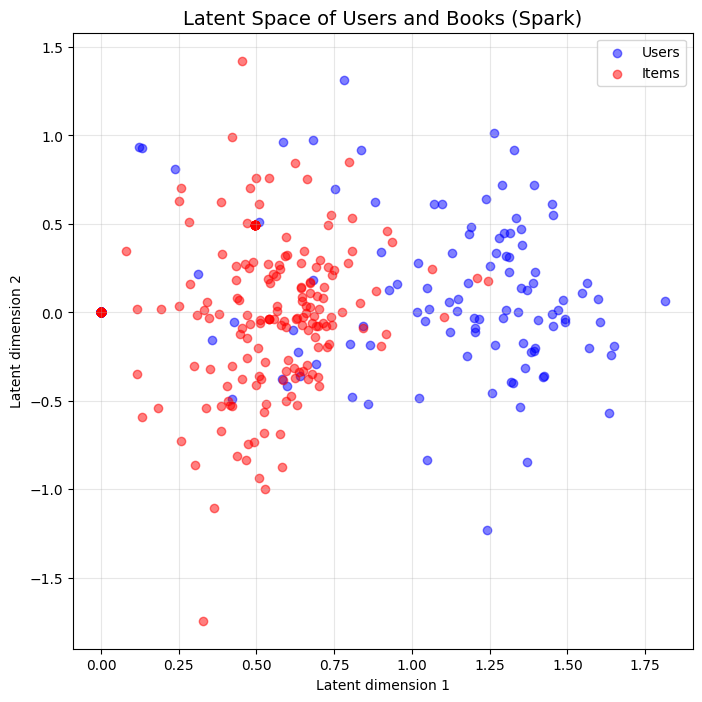

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import builtins  # to avoid Spark min() shadowing

def plot_uv_space(w_final, v_final, n_users=200, n_items=200):

    user_idx = np.random.choice(
        w_final.shape[0],
        size=builtins.min(n_users, w_final.shape[0]),
        replace=False
    )
    item_idx = np.random.choice(
        v_final.shape[0],
        size=builtins.min(n_items, v_final.shape[0]),
        replace=False
    )

    plt.figure(figsize=(8, 8))
    plt.scatter(w_final[user_idx,0], w_final[user_idx,1], alpha=0.5, color="blue", label="Users")
    plt.scatter(v_final[item_idx,0], v_final[item_idx,1], alpha=0.5, color="red", label="Items")

    plt.title("Latent Space of Users and Books (Spark)", fontsize=14)
    plt.xlabel("Latent dimension 1")
    plt.ylabel("Latent dimension 2")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

plot_uv_space(w_final, v_final)